<center><img src="https://keras.io/img/logo-small.png" alt="Keras logo" width="100"><br/>
This starter notebook is provided by the Keras team.</center>

# Inference Notebook

# RSNA 2023 Abdominal Trauma Detection with [KerasCV](https://github.com/keras-team/keras-cv) and [KerasCore](https://github.com/keras-team/keras-core)

This notebook walks you through how to submit to the RSNA 2023 Abdominal Trauma Detection competition.

## Notebooks

For this competition we have two starter notebook. This notebook (you are reading) infers on the trained model. To understand how the model was trained from scratch please visit the training kernel.

1. [**Training Kernel**](https://www.kaggle.com/code/aritrag/kerascv-starter-notebook-train)
2. [**Inference Kernel**](https://www.kaggle.com/code/aritrag/kerascv-starter-notebook-infer)

**Note**: [KerasCV guides](https://keras.io/guides/keras_cv/) is the place to go for a deeper understanding of KerasCV individually.

# Imports and Setup

Please install namex, keras-cv and keras-core for this notebook to work!

Note: We will very soon have keras and keras models accessible from offline notebook =D 

In [1]:
! pip install -q /kaggle/input/keras-cv-core-namex/namex-0.0.7-py3-none-any.whl
! pip install -q /kaggle/input/keras-cv-core-namex/keras_core-0.1.4-py3-none-any.whl
! pip install -q /kaggle/input/keras-cv-core-namex/keras_cv-0.6.1-py3-none-any.whl

In [2]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras_core as keras
import keras_cv

import gc
import cv2
import pydicom
from joblib import Parallel, delayed

import tensorflow as tf
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from glob import glob

Using TensorFlow backend


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [9]:
BASE_PATH = "/kaggle/input/rsna-2023-abdominal-trauma-detection"
IMAGE_DIR = "/tmp/dataset/rsna-atd"
INPUT_MODEL_PATH = "/kaggle/input/kerascv-starter-notebook-train-1baaf6/rsna-atd.keras"
MODEL_PATH = "/kaggle/working/rsna-atd.keras"
STRIDE = 10

In [10]:
class Config:
    IMAGE_SIZE = [256, 256]
    RESIZE_DIM = 256
    BATCH_SIZE = 64
    AUTOTUNE = tf.data.AUTOTUNE
    TARGET_COLS  = ["bowel_healthy", "bowel_injury", "extravasation_healthy",
                   "extravasation_injury", "kidney_healthy", "kidney_low",
                   "kidney_high", "liver_healthy", "liver_low", "liver_high",
                   "spleen_healthy", "spleen_low", "spleen_high"]

config = Config()

# Initialize the Trained Model

Refer to the [training kernel](https://www.kaggle.com/code/aritrag/kerascv-starter-notebook-train) to understand how we have trained the model.

Here we initialize the trained model.

In [11]:
! cp {INPUT_MODEL_PATH} ./

model = keras.models.load_model(MODEL_PATH)
model.summary()

cp: cannot stat '/kaggle/input/kerascv-starter-notebook-train-1baaf6/rsna-atd.keras': No such file or directory


ValueError: File not found: filepath=/kaggle/working/rsna-atd.keras. Please ensure the file is an accessible `.keras` zip file.

# Data Pipeline

We have a model that accepts image in the PNG format. We will now convert the DICOM images to PNG for the model to infer.

In [12]:
meta_df = pd.read_csv(f"{BASE_PATH}/test_series_meta.csv")

# Checking if patients are repeated by finding the number of unique patient IDs
num_rows = meta_df.shape[0]
unique_patients = meta_df["patient_id"].nunique()

print(f"{num_rows=}")
print(f"{unique_patients=}")

num_rows=6
unique_patients=3


In [13]:
meta_df["dicom_folder"] = BASE_PATH + "/" + "test_images"\
                                    + "/" + meta_df.patient_id.astype(str)\
                                    + "/" + meta_df.series_id.astype(str)

test_folders = meta_df.dicom_folder.tolist()
test_paths = []
for folder in tqdm(test_folders):
    test_paths += sorted(glob(os.path.join(folder, "*dcm")))[::STRIDE]

  0%|          | 0/6 [00:00<?, ?it/s]

In [14]:
test_df = pd.DataFrame(test_paths, columns=["dicom_path"])
test_df["patient_id"] = test_df.dicom_path.map(lambda x: x.split("/")[-3]).astype(int)
test_df["series_id"] = test_df.dicom_path.map(lambda x: x.split("/")[-2]).astype(int)
test_df["instance_number"] = test_df.dicom_path.map(lambda x: x.split("/")[-1].replace(".dcm","")).astype(int)

test_df["image_path"] = f"{IMAGE_DIR}/test_images"\
                    + "/" + test_df.patient_id.astype(str)\
                    + "/" + test_df.series_id.astype(str)\
                    + "/" + test_df.instance_number.astype(str) +".png"

test_df.head(2)

,dicom_path,patient_id,series_id,instance_number,image_path
0,/kaggle/input/rsna-2023-abdominal-trauma-detec...,48843,62825,30,/tmp/dataset/rsna-atd/test_images/48843/62825/...
1,/kaggle/input/rsna-2023-abdominal-trauma-detec...,50046,24574,30,/tmp/dataset/rsna-atd/test_images/50046/24574/...


In [15]:
# Checking if patients are repeated by finding the number of unique patient IDs
num_rows = test_df.shape[0]
unique_patients = test_df["patient_id"].nunique()

print(f"{num_rows=}")
print(f"{unique_patients=}")

num_rows=3
unique_patients=3


## DICOM to PNG pipeline

In [16]:
!rm -r {IMAGE_DIR}
os.makedirs(f"{IMAGE_DIR}/train_images", exist_ok=True)
os.makedirs(f"{IMAGE_DIR}/test_images", exist_ok=True)

rm: cannot remove '/tmp/dataset/rsna-atd': No such file or directory


In [17]:
def standardize_pixel_array(dcm):
    # Correct DICOM pixel_array if PixelRepresentation == 1.
    pixel_array = dcm.pixel_array
    if dcm.PixelRepresentation == 1:
        bit_shift = dcm.BitsAllocated - dcm.BitsStored
        dtype = pixel_array.dtype 
        new_array = (pixel_array << bit_shift).astype(dtype) >>  bit_shift
        pixel_array = pydicom.pixel_data_handlers.util.apply_modality_lut(new_array, dcm)
    return pixel_array

def read_xray(path, fix_monochrome=True):
    dicom = pydicom.dcmread(path)
    data = standardize_pixel_array(dicom)
    data = data - np.min(data)
    data = data / (np.max(data) + 1e-5)
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = 1.0 - data
    return data

def resize_and_save(file_path):
    img = read_xray(file_path)
    h, w = img.shape[:2]  # orig hw
    img = cv2.resize(img, (config.RESIZE_DIM, config.RESIZE_DIM), cv2.INTER_LINEAR)
    img = (img * 255).astype(np.uint8)
    
    sub_path = file_path.split("/",4)[-1].split(".dcm")[0] + ".png"
    infos = sub_path.split("/")
    sub_path = file_path.split("/",4)[-1].split(".dcm")[0] + ".png"
    infos = sub_path.split("/")
    pid = infos[-3]
    sid = infos[-2]
    iid = infos[-1]; iid = iid.replace(".png","")
    new_path = os.path.join(IMAGE_DIR, sub_path)
    os.makedirs(new_path.rsplit("/",1)[0], exist_ok=True)
    cv2.imwrite(new_path, img)
    return

In [18]:
%%time

file_paths = test_df.dicom_path.tolist()
_ = Parallel(n_jobs=2, backend="threading")(
    delayed(resize_and_save)(file_path) for file_path in tqdm(file_paths, leave=True, position=0)
)

del _; gc.collect()

  0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 316 ms, sys: 60 ms, total: 376 ms
Wall time: 407 ms


322

## Building the tf.data pipeline

In [19]:
def decode_image(image_path):
    file_bytes = tf.io.read_file(image_path)
    image = tf.io.decode_png(file_bytes, channels=3, dtype=tf.uint8)
    image = tf.image.resize(image, config.IMAGE_SIZE, method="bilinear")
    image = tf.cast(image, tf.float32) / 255.0
    return image

def build_dataset(image_paths):
    ds = (
        tf.data.Dataset.from_tensor_slices(image_paths)
        .map(decode_image, num_parallel_calls=config.AUTOTUNE)
        .shuffle(config.BATCH_SIZE * 10)
        .batch(config.BATCH_SIZE)
        .prefetch(config.AUTOTUNE)
    )
    return ds

In [20]:
paths  = test_df.image_path.tolist()

ds = build_dataset(paths)
images = next(iter(ds))

images.shape

TensorShape([3, 256, 256, 3])

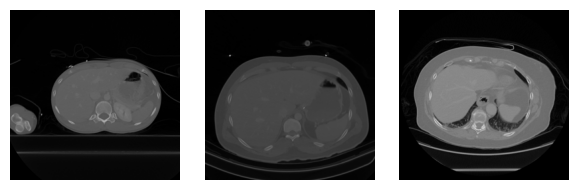

In [21]:
keras_cv.visualization.plot_image_gallery(
    images=images,
    value_range=(0, 1),
    rows=1,
    cols=3,
)

# Inference

In [22]:
def post_proc(pred):
    proc_pred = np.empty((pred.shape[0], 2*2 + 3*3), dtype="float32")

    # bowel, extravasation
    proc_pred[:, 0] = pred[:, 0]
    proc_pred[:, 1] = 1 - proc_pred[:, 0]
    proc_pred[:, 2] = pred[:, 1]
    proc_pred[:, 3] = 1 - proc_pred[:, 2]
    
    # liver, kidney, sneel
    proc_pred[:, 4:7] = pred[:, 2:5]
    proc_pred[:, 7:10] = pred[:, 5:8]
    proc_pred[:, 10:13] = pred[:, 8:11]

    return proc_pred

In [23]:
# Getting unique patient IDs from test dataset
patient_ids = test_df["patient_id"].unique()

# Initializing array to store predictions
patient_preds = np.zeros(
    shape=(len(patient_ids), 2*2 + 3*3),
    dtype="float32"
)

# Iterating over each patient
for pidx, patient_id in tqdm(enumerate(patient_ids), total=len(patient_ids), desc="Patients "):
    print(f"Patient ID: {patient_id}")
    
    # Query the dataframe for a particular patient
    patient_df = test_df.query("patient_id == @patient_id")
    
    # Getting image paths for a patient
    patient_paths = patient_df.image_path.tolist()

    # Building dataset for prediction
    dtest = build_dataset(patient_paths)
    
    # Predicting with the model
    pred = model.predict(dtest)
    pred = np.concatenate(pred, axis=-1).astype("float32")
    pred = pred[:len(patient_paths), :]
    pred = np.mean(pred.reshape(1, len(patient_paths), 11), axis=0)
    pred = np.max(pred, axis=0, keepdims=True)
    
    patient_preds[pidx, :] += post_proc(pred)[0]
    

    # Deleting variables to free up memory 
    del patient_df, patient_paths, dtest, pred; gc.collect()

Patients :   0%|          | 0/3 [00:00<?, ?it/s]

Patient ID: 48843


ValueError: Expression (patient_id) == (__pd_eval_local_patient_id) has forbidden control characters.

# Submission

In [24]:
!rm -rf {MODEL_PATH}

In [25]:
# Create Submission
pred_df = pd.DataFrame({"patient_id":patient_ids,})
pred_df[config.TARGET_COLS] = patient_preds.astype("float32")

# Align with sample submission
sub_df = pd.read_csv(f"{BASE_PATH}/sample_submission.csv")
sub_df = sub_df[["patient_id"]]
sub_df = sub_df.merge(pred_df, on="patient_id", how="left")

# Store submission
sub_df.to_csv("submission.csv",index=False)
sub_df.head(2)

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high
0,48843,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,50046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
